<a href="https://colab.research.google.com/github/seokhee516/Project2-Credit-Scoring-System/blob/main/%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 데이터 및 모듈 불러오기 (추후 합치기)

In [1]:
# !pip install category_encoders

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [19]:
# 데이터 불러오기
df = pd.read_csv('Lending_club_data_2018-2020Q3_preprocessed.csv').iloc[:-1,1:]
# Default == 1, Paid == 0
df.loc[df['loan_payment']=='Default', 'loan_payment'] = 1
df.loc[df['loan_payment']=='Paid', 'loan_payment'] = 0

print(df.shape)
df.head()

(110836, 85)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,...,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_payment
0,133154854.0,28000.0,28000.0,28000.0,60 months,14.03,651.95,C,C2,10+ years,MORTGAGE,125000.0,Verified,May-2018,Charged Off,General loan debt,Home improvement,16.68,0.0,685.0,689.0,0.0,13.0,0.0,40882.0,75.8,22.0,w,679.0,675.0,Individual,0.0,167.0,355111.0,0.0,1.0,0.0,0.0,32.0,2933.0,...,53900.0,1.0,0.0,2.0,1.0,27316.0,5197.0,81.4,0.0,0.0,243.0,264.0,12.0,12.0,1.0,12.0,10.0,0.0,6.0,9.0,7.0,8.0,8.0,11.0,13.0,9.0,13.0,0.0,0.0,0.0,1.0,95.5,57.1,0.0,0.0,423905.0,43815.0,28000.0,19068.0,1
1,133296608.0,6025.0,6025.0,6025.0,36 months,9.58,193.23,B,B1,10+ years,MORTGAGE,75000.0,Verified,May-2018,Fully Paid,debt_consolidation,Debt consolidation,8.81,0.0,660.0,664.0,0.0,3.0,0.0,0.0,0.0,18.0,w,669.0,665.0,Joint App,0.0,0.0,396237.0,0.0,1.0,0.0,1.0,23.0,31047.0,...,800.0,1.0,1.0,1.0,2.0,132079.0,800.0,0.0,0.0,0.0,106.0,121.0,42.0,11.0,6.0,42.0,10.0,6.0,0.0,0.0,1.0,5.0,5.0,1.0,7.0,0.0,3.0,0.0,0.0,0.0,1.0,61.1,0.0,0.0,0.0,408401.0,31047.0,800.0,38249.0,0
2,133465963.0,9000.0,9000.0,9000.0,36 months,11.05,294.87,B,B4,less than 3 years,MORTGAGE,140000.0,Not Verified,May-2018,Current,debt_consolidation,Debt consolidation,10.59,0.0,695.0,699.0,0.0,8.0,0.0,9024.0,41.8,35.0,w,709.0,705.0,Individual,0.0,0.0,54836.0,2.0,2.0,2.0,3.0,8.0,45812.0,...,21600.0,1.0,4.0,6.0,8.0,6855.0,2662.0,72.0,0.0,0.0,144.0,183.0,4.0,4.0,4.0,5.0,4.0,0.0,2.0,3.0,2.0,6.0,19.0,6.0,12.0,3.0,8.0,0.0,0.0,0.0,5.0,97.1,50.0,0.0,0.0,81369.0,54836.0,9500.0,59769.0,0
3,133498757.0,25000.0,25000.0,25000.0,36 months,10.07,807.51,B,B2,10+ years,MORTGAGE,86800.0,Source Verified,May-2018,Current,debt_consolidation,Debt consolidation,18.14,0.0,675.0,679.0,0.0,26.0,0.0,34132.0,45.8,50.0,w,659.0,655.0,Individual,0.0,0.0,218306.0,0.0,0.0,0.0,0.0,60.0,0.0,...,74600.0,0.0,1.0,1.0,11.0,8732.0,12603.0,67.4,0.0,0.0,140.0,266.0,10.0,10.0,1.0,14.0,10.0,0.0,11.0,20.0,12.0,19.0,3.0,25.0,46.0,20.0,26.0,0.0,0.0,0.0,1.0,98.0,81.8,0.0,0.0,264608.0,34132.0,38700.0,0.0,0
4,133843310.0,10000.0,10000.0,10000.0,60 months,14.52,235.39,C,C3,10+ years,RENT,36000.0,Not Verified,May-2018,Fully Paid,General loan debt,Home improvement,20.03,0.0,770.0,774.0,0.0,13.0,0.0,4867.0,17.7,17.0,w,744.0,740.0,Joint App,0.0,0.0,18659.0,0.0,1.0,0.0,0.0,35.0,13792.0,...,27500.0,0.0,0.0,0.0,2.0,1555.0,11854.0,26.4,0.0,0.0,72.0,167.0,19.0,19.0,0.0,19.0,20.0,0.0,3.0,4.0,7.0,8.0,2.0,12.0,15.0,4.0,13.0,0.0,0.0,0.0,0.0,100.0,28.6,0.0,0.0,51989.0,18659.0,16100.0,24489.0,0


In [4]:
# 빈도가 100%인 변수 제거
df.drop(columns=['num_tl_120dpd_2m', 'acc_now_delinq', 'num_tl_30dpd'],axis=1, inplace=True)

# 3. 모델링

In [5]:
# 평가지표 함수
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    print("Model_Evaluation with Label: Default")
    print("Accuracy: ", Accuracy)
    print("Precision: ", Precision)
    print("Recall: ", Recall)
    print("F1-Score: ", F1_Score)

## 3.1 타겟 지정 및 데이터 세트 분할

In [17]:
df[df['issue_d'] == 'Sep-2020']

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,...,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_payment


In [6]:
target= 'loan_payment'

# test set 만들기
test = df[(df['issue_d'] == 'Sep-2020') | (df['issue_d'] == 'May-2020')]
train = df.drop(test.index)

# validation set 만들기
train, val = train_test_split(train, train_size = 0.8, stratify=train[target], random_state=10)

In [7]:
# target 지정 및 데이터 세트 분할
# loan_payment: Target, id: Always unique, issue_d: Date, grade: Duplicative of sub_grade
features = train.drop(columns=['loan_status','loan_payment','id','issue_d','grade']).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [8]:
print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88668, 77)
X_val shape (22168, 77)
X_test shape (0, 77)


In [15]:
# Data Processing Pipeline
processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

# Scailing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_val_scaled = scaler.transform(X_val_processed)

## 3.2 기본값 모델링

In [10]:
y_train.value_counts(normalize=True)

0    0.886724
1    0.113276
Name: loan_payment, dtype: float64

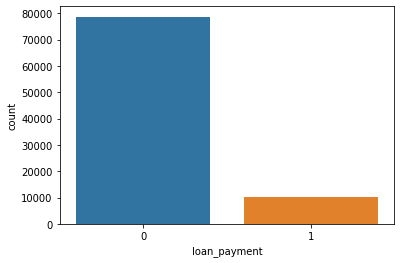

In [11]:
sns.countplot(x=y_train)

In [12]:
# Majority class baseline
# 기준모델 학습세트
major = y_train.mode()[0]
y_pred = [major] *len(y_train)
print("기준모델 학습세트 평가")
model_evaluation(y_train, y_pred)
print("\n")

# 기준모델 검증세트
y_val = val[target]
y_pred = [major] * len(y_val)
print("기준모델 검증세트 평가")
model_evaluation(y_val, y_pred)

기준모델 학습세트 평가


ValueError: ignored

In [13]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [14]:
# Logistic Regression
lr = LogisticRegression(random_state=10, n_jobs=-1)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr)

ValueError: ignored

In [ ]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(X_train_processed, y_train)
y_pred_dtc = dtc.predict(X_val_processed)

print("결정트리 검증세트 평가")
model_evaluation(y_val, y_pred_dtc)

## 3.4 SMOTE를 이용한 Oversampling 후 모델링

In [ ]:
print("OverSampling 전, 'Default' 라벨의 수: {}".format(sum(y_train == 'Default')))
print("OverSampling 전, 'Paid' 라벨의 수: {}".format(sum(y_train == 'Paid')))

In [ ]:
# SMOTE 알고리즘 활용하여 Oversampling 진행
sm = SMOTE(random_state = 10, ratio = 0.3) 
X_train_res, y_train_res = sm.fit_sample(X_train_processed, y_train.ravel()) 

In [ ]:
print("OverSampling 후, 'Default' 라벨의 수: {}".format(sum(y_train_res == 'Default')))
print("OverSampling 후, 'Paid' 라벨의 수: {}".format(sum(y_train_res == 'Paid')))

In [ ]:
pd.Series(y_train_res).value_counts(normalize=True)

In [ ]:
sns.countplot(x=pd.Series(y_train_res))

In [ ]:
# Logistic Regression Over Sampling
lr2 = LogisticRegression(random_state=10, n_jobs=-1)
lr2.fit(X_train_res, y_train_res)
y_pred_lr2 = lr2.predict(X_val_scaled)

print("로지스틱 검증세트 평가")
model_evaluation(y_val, y_pred_lr2)

In [ ]:
# Decision Tree Classifier Over Sampling
dtc2 = DecisionTreeClassifier(random_state=10)
dtc2.fit(X_train_res, y_train_res)
y_pred_dtc2 = dtc2.predict(X_val_processed)

print("결정트리 검증세트 평가")
model_evaluation(y_val, y_pred_dtc2)

In [ ]:
# Random Forest Classifier Over Sampling
rfc2 = RandomForestClassifier(random_state=1, n_jobs=-1)
rfc2.fit(X_train_res, y_train_res)
y_pred_rfc2 = rfc2.predict(X_val_processed)

print("렌덤포레스트 검증세트 평가")
model_evaluation(y_val, y_pred_rfc2)

# 3.5 Hyperparameter Tuning 후 모델링

In [ ]:
vc = y_train.value_counts().to_list()
ratio = float(vc[0]/vc[1])
ratio

In [ ]:
# XGBClassifier Hyperparameter Tuning
xgb3 = XGBClassifier(random_state=10, n_jobs=-1,n_estimators=1000, max_depth=7, 
                     scale_pos_weight=ratio) # weight 조절

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

xgb3.fit(X_train_processed, y_train,
         eval_set=eval_set, eval_metric='error', early_stopping_rounds=50)
y_pred_xgb3 = xgb3.predict(X_val_processed)


print("XGBoost 검증세트 평가")
model_evaluation(y_val, y_pred_xgb3)

# 3.6 Over Sampling + Hyperparameter Tuning 후 모델링

In [ ]:
# RandomForestClassifier Over Sampling + Hyperparameter Tuning
rfc2 = RandomForestClassifier(random_state=10, n_jobs=-1, max_depth=4, n_estimators=300)
rfc2.fit(X_train_res, y_train_res)
y_pred_rfc2 = rfc2.predict(X_val_processed)

print("랜덤포레스트 검증세트 평가")
model_evaluation(y_val, y_pred_rfc2)

## 4. 데이터 다시 전처리
- feature importance 확인
- correlation 확인

In [ ]:
feature_names = X_train.columns.tolist()
pd.Series(xgb3.feature_importances_, feature_names).sort_values(ascending=False)

In [ ]:
sns.distplot(df['last_fico_range_high'])


In [ ]:
df[['loan_payment','last_fico_range_high','funded_amnt_inv']]

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df.drop(columns=['loan_status','id','issue_d','grade']).corr())